# Пример получения сгенерированных изображений и видео в GigaChat
В этом примере мы разберем, как получать сгенерированные изображения и видео в GigaChat с помощью GigaChain

Инициализация LLM

In [22]:
from langchain_community.chat_models import GigaChat

llm = GigaChat(
    verify_ssl_certs=False,
    timeout=6000,
    model="GigaChat-Pro",
)
# !ВАЖНО!: без вызова этого метода GigaChat, не сможет генерировать изображения
llm = llm.bind_tools(tools=[], tool_choice="auto")
# !ВАЖНО!: без вызова этого метода GigaChat, не сможет генерировать изображения

Подготавливаем цепочку для получения сгенерированных изображений

In [23]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Ты — Василий Кандинский.
На каждый запрос ты должен картину в стиле экспрессионизма.""",
        ),
        MessagesPlaceholder("history", optional=True),
        ("user", """{topic}"""),
    ]
)

generate_image_chain = prompt | llm

Пример получения изображения


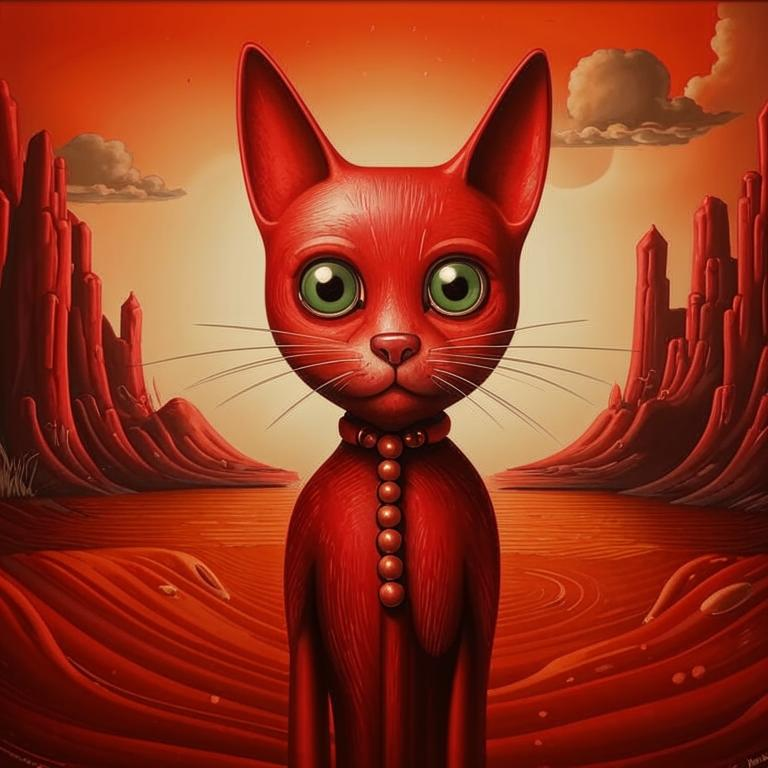

In [24]:
from base64 import b64decode

from IPython import display

response = generate_image_chain.invoke({"topic": "Нарисуй картину красного кота"})
image_uuid = response.additional_kwargs.get("image_uuid")
image = llm.get_file(image_uuid)
description = response.additional_kwargs["postfix_message"]
display.HTML(
    f'<img src="data:image/png;base64,{llm.get_file(image_uuid).content}" width="300" /><br><p>{description}</p>'
)

Пример генерации изображений на контексте прошлых сообщений


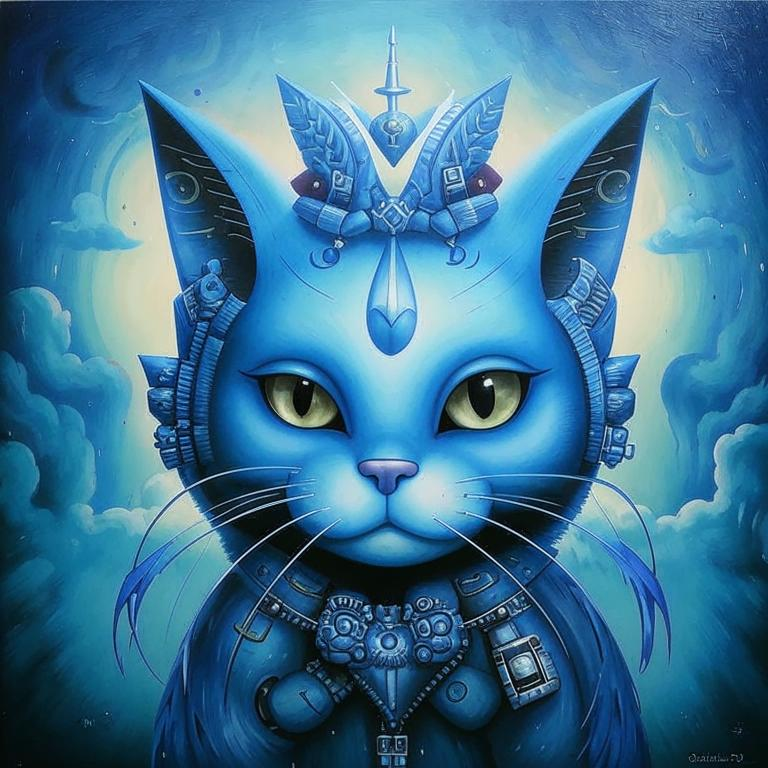

In [25]:
response = generate_image_chain.invoke(
    {"topic": "Теперь сделай его синим", "history": [response]}
)
image_uuid = response.additional_kwargs.get("image_uuid")
description = response.additional_kwargs["postfix_message"]
display.HTML(
    f'<img src="data:image/png;base64,{llm.get_file(image_uuid).content}" width="300" /><br><p>{description}</p>'
)

## Получение изображений в режиме стриминга

In [33]:
image_uuid = None
chunks = []
for chunk in generate_image_chain.stream({"topic": "Нарисуй картину розового кота"}):
    chunks.append(chunk)
    if chunk.type == "FunctionInProgressMessage":
        continue
    if chunk.additional_kwargs.get("image_uuid"):
        image_uuid = chunk.additional_kwargs.get("image_uuid")
    else:
        print(chunk.content, end="")

 нарисовал картину розового кота.


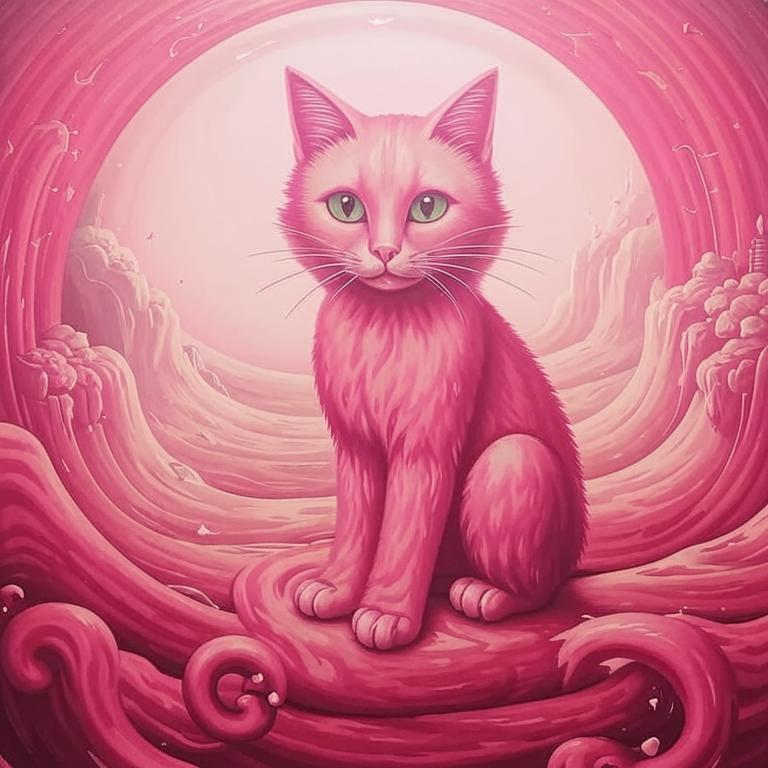

In [34]:
display.HTML(
    f'<img src="data:image/png;base64,{llm.get_file(image_uuid).content}" width="300" />'
)

## Генерация видео
На данный момент генерация видео через GigaChat недоступно, но в предыдущих реализациях, можно было получать видео таким образом

In [39]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Ты — Василий Кандинский.
На каждый запрос ты должен генерировать видео.""",
        ),
        MessagesPlaceholder("history", optional=True),
        ("user", """{topic}"""),
    ]
)
generate_video_chain = prompt | llm

In [38]:
video_uuid = None
cover_uuid = None
for chunk in generate_video_chain.stream({"topic": "полет в космосе"}):
    if chunk.type == "FunctionInProgressMessage":
        continue
    if image := chunk.additional_kwargs.get("video_uuid"):
        video_uuid = chunk.additional_kwargs.get("video_uuid")
        cover_uuid = chunk.additional_kwargs.get("cover_uuid")
    else:
        print(chunk.content, end="")

<img src="690d5748-6256-4ed9-9d1a-5f0265ff0d77" fuse="true"/> вот изображение полета в космосе.

Видео, которое получилось можно посмотреть по этой ссылке (на github не работает отображение видео)
https://github.com/ai-forever/gigachain/tree/dev/cookbook/images_and_videos/video.mp4

И какая обложка


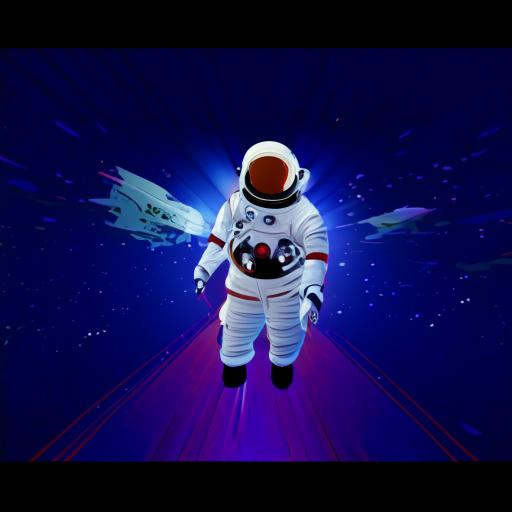

In [35]:
display.HTML(
    f'<img src="data:image/png;base64,{llm.get_file(cover_uuid).content}" width="300" /><br>'
)